In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [3]:
# Step 2: Load the dataset
df = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')
df.dropna(subset=['Customer ID'], inplace=True)  # Drop rows without customer ID

In [4]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [5]:
# Step 3: Data Cleaning
# Remove any returns (negative quantities)
df = df[df['Quantity'] > 0]

In [10]:
# If df is already defined and you want to remove missing values
df = df.dropna(subset=['Customer ID', 'Description'])  # Avoids SettingWithCopyWarning


In [11]:
# Step 4: Feature Engineering - Calculate Monetary, Frequency, and Recency
# Monetary Value (Total amount spent by each customer)
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['Price']

# Group by 'Customer ID' to calculate total monetary value
monetary = df.groupby('Customer ID')['TotalPrice'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']


In [12]:
# Frequency (Number of purchases by each customer)
frequency = df.groupby('Customer ID')['Invoice'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

In [14]:
# Convert InvoiceDate to datetime if not already done
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Get the latest date with an additional day offset
latest_date = df['InvoiceDate'].max() + pd.DateOffset(1)

# Calculate Recency using agg() to avoid the warning
recency = df.groupby('Customer ID')['InvoiceDate'].agg(lambda x: (latest_date - x.max()).days).reset_index()
recency.columns = ['CustomerID', 'Recency']


In [15]:
# Recency (Days since the customer's last purchase)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
latest_date = df['InvoiceDate'].max() + pd.DateOffset(1)
recency = df.groupby('Customer ID').apply(lambda x: (latest_date - x['InvoiceDate'].max()).days).reset_index()
recency.columns = ['CustomerID', 'Recency']

C:\Users\akash\AppData\Local\Temp\ipykernel_396\895709469.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recency = df.groupby('Customer ID').apply(lambda x: (latest_date - x['InvoiceDate'].max()).days).reset_index()


In [16]:
# Merge to create an RFM dataframe
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

In [17]:
# Step 5: CLV Calculation - Predictive Model
# Use Monetary, Frequency, and Recency as predictors for CLV
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Monetary']


In [18]:
# Train a simple Linear Regression model for CLV prediction
model = LinearRegression()
model.fit(X, y)


LinearRegression()

In [19]:
# Make predictions and calculate Mean Absolute Error
rfm['Predicted_CLV'] = model.predict(X)
mae = mean_absolute_error(y, rfm['Predicted_CLV'])
print(f"Mean Absolute Error of CLV Prediction Model: {mae}")

Mean Absolute Error of CLV Prediction Model: 1.4280980196002044e-12


In [20]:
# Step 6: Customer Segmentation using K-Means Clustering
# Normalize the data for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [21]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

In [22]:
# Step 7: Recommendation System - Product Suggestions
# Create a matrix of Customer ID and products purchased
product_df = df.pivot_table(index='Customer ID', columns='StockCode', values='Quantity', aggfunc='sum', fill_value=0)

In [23]:
# Use collaborative filtering for recommendations
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(product_df)

In [28]:
def recommend_products(customer_id, n=5):
    # Check if the customer_id exists in the product_df index
    if customer_id not in product_df.index:
        raise ValueError("Customer ID not found in product_df.")
    
    # Get the index for the customer
    customer_idx = product_df.index.get_loc(customer_id)
    
    # Calculate similarity scores
    similarity_scores = list(enumerate(similarity_matrix[customer_idx]))
    
    # Sort by similarity in descending order
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top n similar customers (skip the first one as it's the customer itself)
    similar_customers = [product_df.index[i[0]] for i in similarity_scores[1:n+1]]
    
    # Find common items purchased by these similar customers
    recommendations_list = []
    for cust_id in similar_customers:
        recommendations_list.append(df[df['Customer ID'] == cust_id][['StockCode', 'Description']])
    
    recommendations = pd.concat(recommendations_list, ignore_index=True)
    
    # Return the most common purchased items
    return recommendations['Description'].value_counts().head(n).index.tolist()


In [29]:
# Example: Get top 5 recommended products for a specific customer ID
customer_id = rfm['CustomerID'].iloc[0]
recommendations = recommend_products(customer_id, n=5)
print(f"Top 5 recommended products for Customer {customer_id}: {recommendations}")

Top 5 recommended products for Customer 12346.0: ['MEDIUM CERAMIC TOP STORAGE JAR', 'ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE IVORY', 'HAND OVER THE CHOCOLATE   SIGN ', 'PARTY METAL SIGN ']


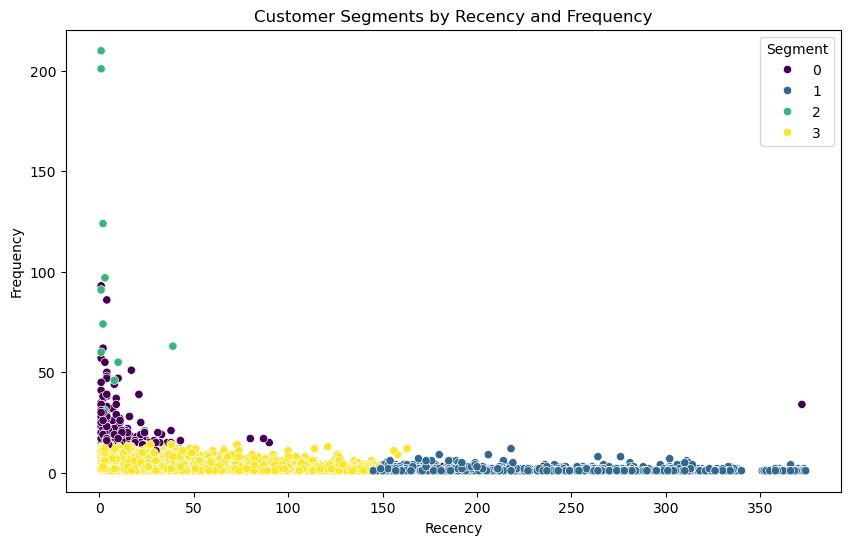

In [30]:
# Step 8: Visualize Customer Segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Segment', data=rfm, palette='viridis')
plt.title("Customer Segments by Recency and Frequency")
plt.xlabel("Recency")
plt.ylabel("Frequency")
plt.show()